In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from simulation import Simulation

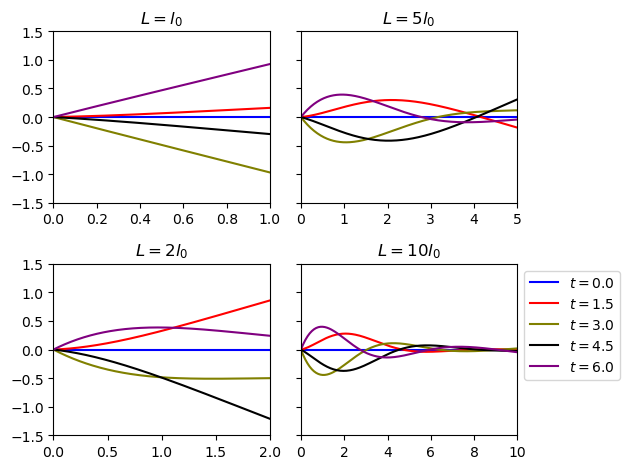

In [2]:
f, ax = plt.subplots(2, 2, sharey=True)
df1 = pd.read_parquet('./data/l1.parquet')
df2 = pd.read_parquet('./data/l2.parquet')
df5 = pd.read_parquet('./data/l5.parquet')
df10 = pd.read_parquet('./data/l10.parquet')
colors = ['blue', 'red', 'olive', 'black', 'purple']
for i in range(5):
    gap = 300000
    time = round(df1['t'][gap*i+1],1)
    ax[0, 0].plot(df1['x'][gap*i:gap*(i)+200], df1['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[1, 0].plot(df2['x'][gap*i:gap*(i)+200], df2['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[0, 1].plot(df5['x'][gap*i:gap*(i)+200], df5['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[1, 1].plot(df10['x'][gap*i:gap*(i)+200], df10['y'][gap*i:gap*(i)+200], label=fr'$t = {time}$', color=colors[i])
    ax[0, 0].set_ylim(-1.5, 1.5)
    ax[0, 0].set_xlim(0, 1)
    ax[1, 0].set_xlim(0, 2)
    ax[0, 1].set_xlim(0, 5)
    ax[1, 1].set_xlim(0, 10)
    ax[0, 0].set_title(r'$L = l_0$')
    ax[1, 0].set_title(r'$L = 2l_0$')
    ax[0, 1].set_title(r'$L = 5l_0$')
    ax[1, 1].set_title(r'$L = 10l_0$')
plt.legend(loc='lower right')
sns.move_legend(ax[1, 1], "upper left", bbox_to_anchor=(1, 1))
f.tight_layout()
plt.savefig('./figures/filaments.png', bbox_inches='tight')

In [3]:
def analytical_y(G, l0, L, f, x, t):
    c8 = np.cos(np.pi/8) # 0.92
    s8 = np.sin(np.pi/8) # 0.38
    theta = x*(c8 - 1j*s8)/l0
    phi = L*(c8 - 1j*s8)/l0
    p1 = G*l0*(np.exp(1j*(f*t + np.pi/8)))
    p2 = 1/(2 + 2*np.cosh(phi)*np.cos(phi))
    p3 = np.sin(theta) + np.sinh(theta) + np.sin(phi)*np.cosh(phi-theta) - np.cos(phi)*np.sinh(phi-theta) - np.cosh(phi)*np.sin(phi-theta) + np.sinh(phi)*np.cos(phi-theta)
    return p1*p2*p3

p = 12
ms = [2**x for x in range(4, p)]
time_errors = np.zeros(p-4)
length = 10*(1/4)**(1/4)
for k, m in enumerate(ms):
    sim = Simulation(timesteps=m,
                     n_points=2000,
                     max_time=10, osc_freq=4,
                     length=10*(1/4)**(1/4), eta=1)
    sim.run()
    y, x, t, _ = sim.get_data()
    dom = np.linspace(0, length, 2000)
    y_full = np.interp(dom, x, y[-1])
    analytical = analytical_y(G=1, l0=(1/4)**(1/4), L=10*(1/4)**(1/4), f=4, x=dom, t=t[-1])
    time_errors[k] = np.abs(np.real(y_full) - np.real(analytical)).sum()
    
p = 12
ns = [2**x for x in range(4, p)]
space_errors = np.zeros(p-4)
for k, n in enumerate(ns):
    sim = Simulation(timesteps=100000,
                     n_points=n,
                     max_time=10, osc_freq=4,
                     length=10*(1/4)**(1/4), eta=1)
    sim.run()
    y, x, t, _ = sim.get_data()
    dom = np.linspace(0, length, 200000)
    y_full = np.interp(dom, x, y[-1])
    analytical = analytical_y(G=1, l0=(1/4)**(1/4), L=10*(1/4)**(1/4), f=4, x=dom, t=t[-1])
    space_errors[k] = np.abs(np.real(y_full) - np.real(analytical)).sum()

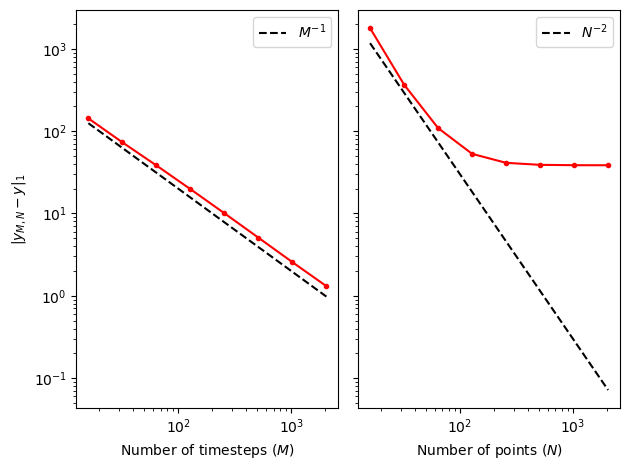

In [4]:
f, ax = plt.subplots(1, 2, sharey=True,)
ax[0].loglog(ms, time_errors, color='red', marker='.')
ax[0].loglog(ms, 2000*1/np.power(ms, 1), linestyle='--', color='black', label='$M^{-1}$')
ax[0].set_xlabel('Number of timesteps ($M$)')
ax[0].set_ylabel('$|y_{M,N} - y|_1$')
ax[0].legend()

ax[1].loglog(ns, space_errors, color='red', marker='.')
ax[1].loglog(ns, 300000*1/np.power(ns, 2), linestyle='--', color='black', label='$N^{-2}$')
ax[1].set_xlabel('Number of points ($N$)')
ax[1].legend()
f.tight_layout()
plt.savefig('./figures/all_errors.png', bbox_inches='tight')